# Линейные методы классификации и регрессии: метод стохастического градиента

## Библиотеки

In [12]:
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tqdm'

### Задание 1

Сгенерировать множество точек с некоторой зависимостью (на ваш выбор).

Применив линейную модель восстановить эту зависимость, выписать метрики качества (3-4 штуки).

Приветствуется визуализация

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

MSE: 3.260
MAE: 1.430
R^2: 0.943


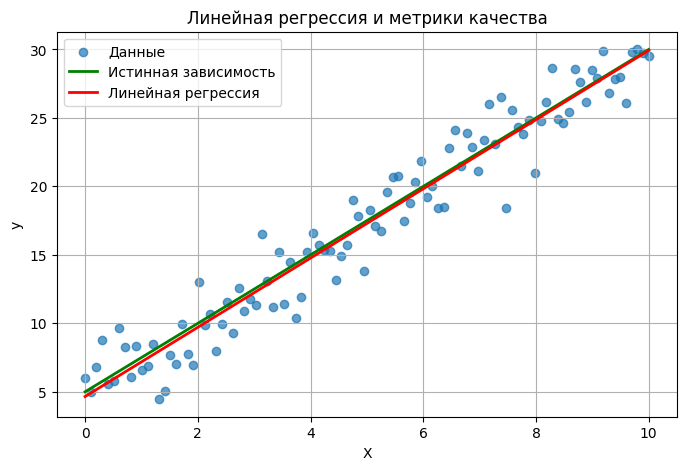

In [ ]:
np.random.seed(42)
l = 100
X = np.linspace(0, 10, l).reshape(-1, 1)
y_true = 2.5 * X.flatten() + 5
noise = np.random.normal(0, 2, l)
y = y_true + noise

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Метрики качества
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")

plt.figure(figsize=(8, 5))
plt.scatter(X, y, label='Данные', alpha=0.7)
plt.plot(X, y_true, label='Истинная зависимость', color='green', linewidth=2)
plt.plot(X, y_pred, label='Линейная регрессия', color='red', linewidth=2)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Линейная регрессия и метрики качества')
plt.legend()
plt.grid(True)
plt.show()

### Задание 2

Сгенерировать множество точек 3 классов.

Применив логистическую регрессию и SVM восстановить оптимальную разделяющую гиперплоскость, выписать метрики качества (3 штуки).

Приветствуется визуализация

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from matplotlib.colors import ListedColormap

OneVsRest Logistic Regression:
Accuracy: 0.98
F1: 0.979854443904063
Confusion matrix:
 [[50  0  0]
 [ 0 50  0]
 [ 1  2 47]]

SVM:
Accuracy: 0.9866666666666667
F1: 0.986596618845558
Confusion matrix:
 [[50  0  0]
 [ 0 50  0]
 [ 1  1 48]]


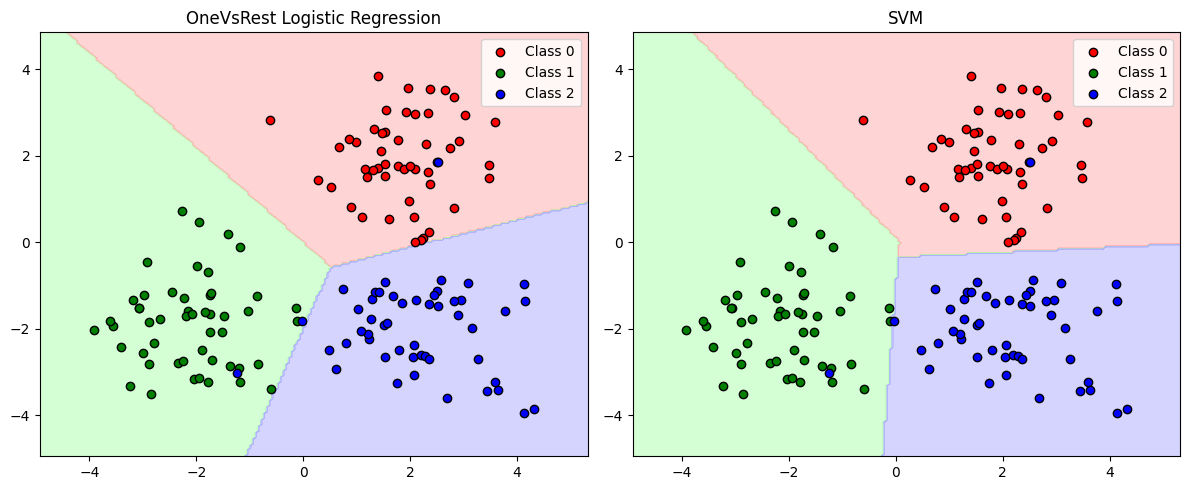

In [ ]:
np.random.seed(42)
l = 150
X1 = np.random.randn(l//3, 2) + [2, 2]
X2 = np.random.randn(l//3, 2) + [-2, -2]
X3 = np.random.randn(l//3, 2) + [2, -2]
X = np.vstack([X1, X2, X3])
y = np.array([0]*(l//3) + [1]*(l//3) + [2]*(l//3))

# One-vs-Rest Logistic Regression
# Нужен ли ovr или просили просто SVM с линейным ядром?
ovr_logreg = OneVsRestClassifier(LogisticRegression())
ovr_logreg.fit(X, y)
y_pred_logreg = ovr_logreg.predict(X)

# SVM
svm = SVC(kernel='linear')
svm.fit(X, y)
y_pred_svm = svm.predict(X)

print('OneVsRest Logistic Regression:')
print('Accuracy:', accuracy_score(y, y_pred_logreg))
print('F1:', f1_score(y, y_pred_logreg, average='macro'))
print('Confusion matrix:\n', confusion_matrix(y, y_pred_logreg))

print('\nSVM:')
print('Accuracy:', accuracy_score(y, y_pred_svm))
print('F1:', f1_score(y, y_pred_svm, average='macro'))
print('Confusion matrix:\n', confusion_matrix(y, y_pred_svm))

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ['red', 'green', 'blue']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for idx, (model, title, y_pred) in enumerate([
    (ovr_logreg, 'OneVsRest Logistic Regression', y_pred_logreg),
    (svm, 'SVM', y_pred_svm)
]):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axes[idx].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)
    for i, color in enumerate(cmap_bold):
        axes[idx].scatter(X[y==i, 0], X[y==i, 1], c=color, label=f'Class {i}', edgecolor='k')
    axes[idx].set_title(title)
    axes[idx].legend()
plt.tight_layout()
plt.show()